In [8]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import numpy as np
from torch.nn import functional as F
from components.resnet import build_resnet50
import pandas as pd
from tqdm import tqdm
from torchattacks import PGD, FGSM
from pathlib import Path

ModuleNotFoundError: No module named 'components'

In [4]:
root_dir = Path('/home/mathepa1/vscode-projects/mirror-mirror/output/cifar10_random_09_18_24/forget_random_300')
run_number = 0
unlearning_method = 'amnesiac'

NameError: name 'Path' is not defined

In [2]:
run_dir = root_dir / f'run_{run_number}' 
forget_set = run_dir / 'forget_set.csv'
orig_model_path = root_dir.parent / 'original' / 'original_state_dict.pt'
unlearned_model_path, control_model_path = run_dir / unlearning_method / f'{unlearning_method}_state_dict.pt', run_dir / 'control' / 'control_state_dict.pt'

NameError: name 'root_dir' is not defined

In [21]:
ds_index = pd.read_csv(str(forget_set))['sample_ind'].to_numpy()
CIFAR_MEAN, CIFAR_STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ]
)
clean_ds = torchvision.datasets.CIFAR10('./data', transform=transform, download=True)
clean_ds = torch.utils.data.Subset(clean_ds, ds_index)

Files already downloaded and verified


In [22]:
orig_model, control_model, unlearned_model = build_resnet50(10, 3).cuda(), build_resnet50(10, 3).cuda(), build_resnet50(10, 3).cuda()
orig_model.load_state_dict(torch.load(str(orig_model_path)))
control_model.load_state_dict(torch.load(str(control_model_path)))
unlearned_model.load_state_dict(torch.load(str(unlearned_model_path)))
orig_model.eval()
control_model.eval()
unlearned_model.eval();

In [23]:
def plot_img(img, ax):
    ax.imshow((img.permute(1, 2, 0).cpu() * np.array(CIFAR_STD)) + np.array(CIFAR_MEAN))

In [105]:
def get_adv_imgs(model, clean_ds, mu, sigma):
    # atk = PGD(model, eps=epsilon, alpha=alpha)
    # print(atk.device)
    # atk.set_device(torch.device('cuda:0'))
    # atk.set_normalization_used(CIFAR_MEAN, CIFAR_STD)
    # atk.set_mode_targeted_by_function(lambda x, y: y)

    test_dl = torch.utils.data.DataLoader(clean_ds, batch_size=128)
    adv_imgs = []
    num_correct = 0
    for imgs, labels in test_dl:
        batch_adv_imgs = imgs + torch.normal(mu, sigma, imgs.shape)
        # batch_adv_imgs = atk(imgs, labels)
        preds = F.softmax(model(batch_adv_imgs.float().cuda()), dim=-1).argmax(dim=-1)
        num_correct += torch.sum(preds.cpu() == labels).item()
        adv_imgs.extend(batch_adv_imgs)    
    adv_imgs = torch.stack(adv_imgs)
    asr = num_correct / adv_imgs.shape[0]
    
    return asr, adv_imgs
    

In [107]:
asrs, max_asr = [], -np.inf
adv_imgs = None
mus = np.linspace(0, 0.1, 61)
sigmas = np.linspace(0, 1.1, 61)
for sigma in tqdm(sigmas):
    tmp = []
    for mu in mus:
        asr, curr_adv_imgs = get_adv_imgs(
            unlearned_model, 
            clean_ds, 
            mu=mu,
            sigma=sigma
        )
        tmp.append(asr)
        if adv_imgs is None or asr > max_asr:
            adv_imgs = curr_adv_imgs
            max_asr = asr
    asrs.append(tmp)
asrs = np.array(asrs)

100%|██████████| 61/61 [02:45<00:00,  2.71s/it]


Best performance at mu = 0.08333333333333334, sigma^2 = 0.34833333333333333, success rate = 61.33333333333333%


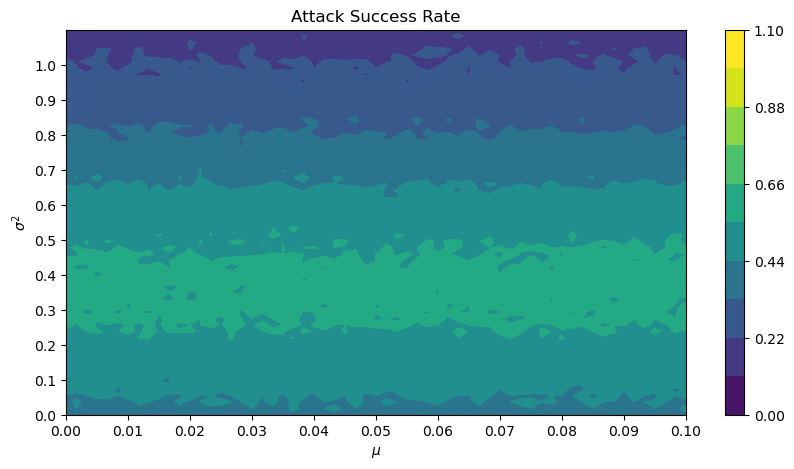

In [124]:
max_asr_inds = np.unravel_index(np.argmax(asrs), asrs.shape)
print(f'Best performance at mu = {mus[max_asr_inds[1]]}, sigma^2 = {sigmas[max_asr_inds[0]]}, success rate = {100 * asrs[max_asr_inds]}%')
plt.figure(figsize=(10, 5))
xx, yy = np.meshgrid(mus, sigmas)
plt.contourf(xx, yy, asrs, vmin=0, vmax=1, levels=np.linspace(0, 1.1, 11))
# plt.scatter(y=mus[max_asr_inds[1]], x=sigmas[max_asr_inds[0]], s=100, c='red', marker='*',zorder=100)
plt.xticks(np.arange(0, 0.11, step=0.01))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title("Attack Success Rate")#\n(Red star indicates best performance)")
plt.ylabel("$\\sigma^2$")
plt.xlabel("$\\mu$")
plt.colorbar()
plt.show()


100%|██████████| 300/300 [00:01<00:00, 241.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 65 examples of recovered behavior


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


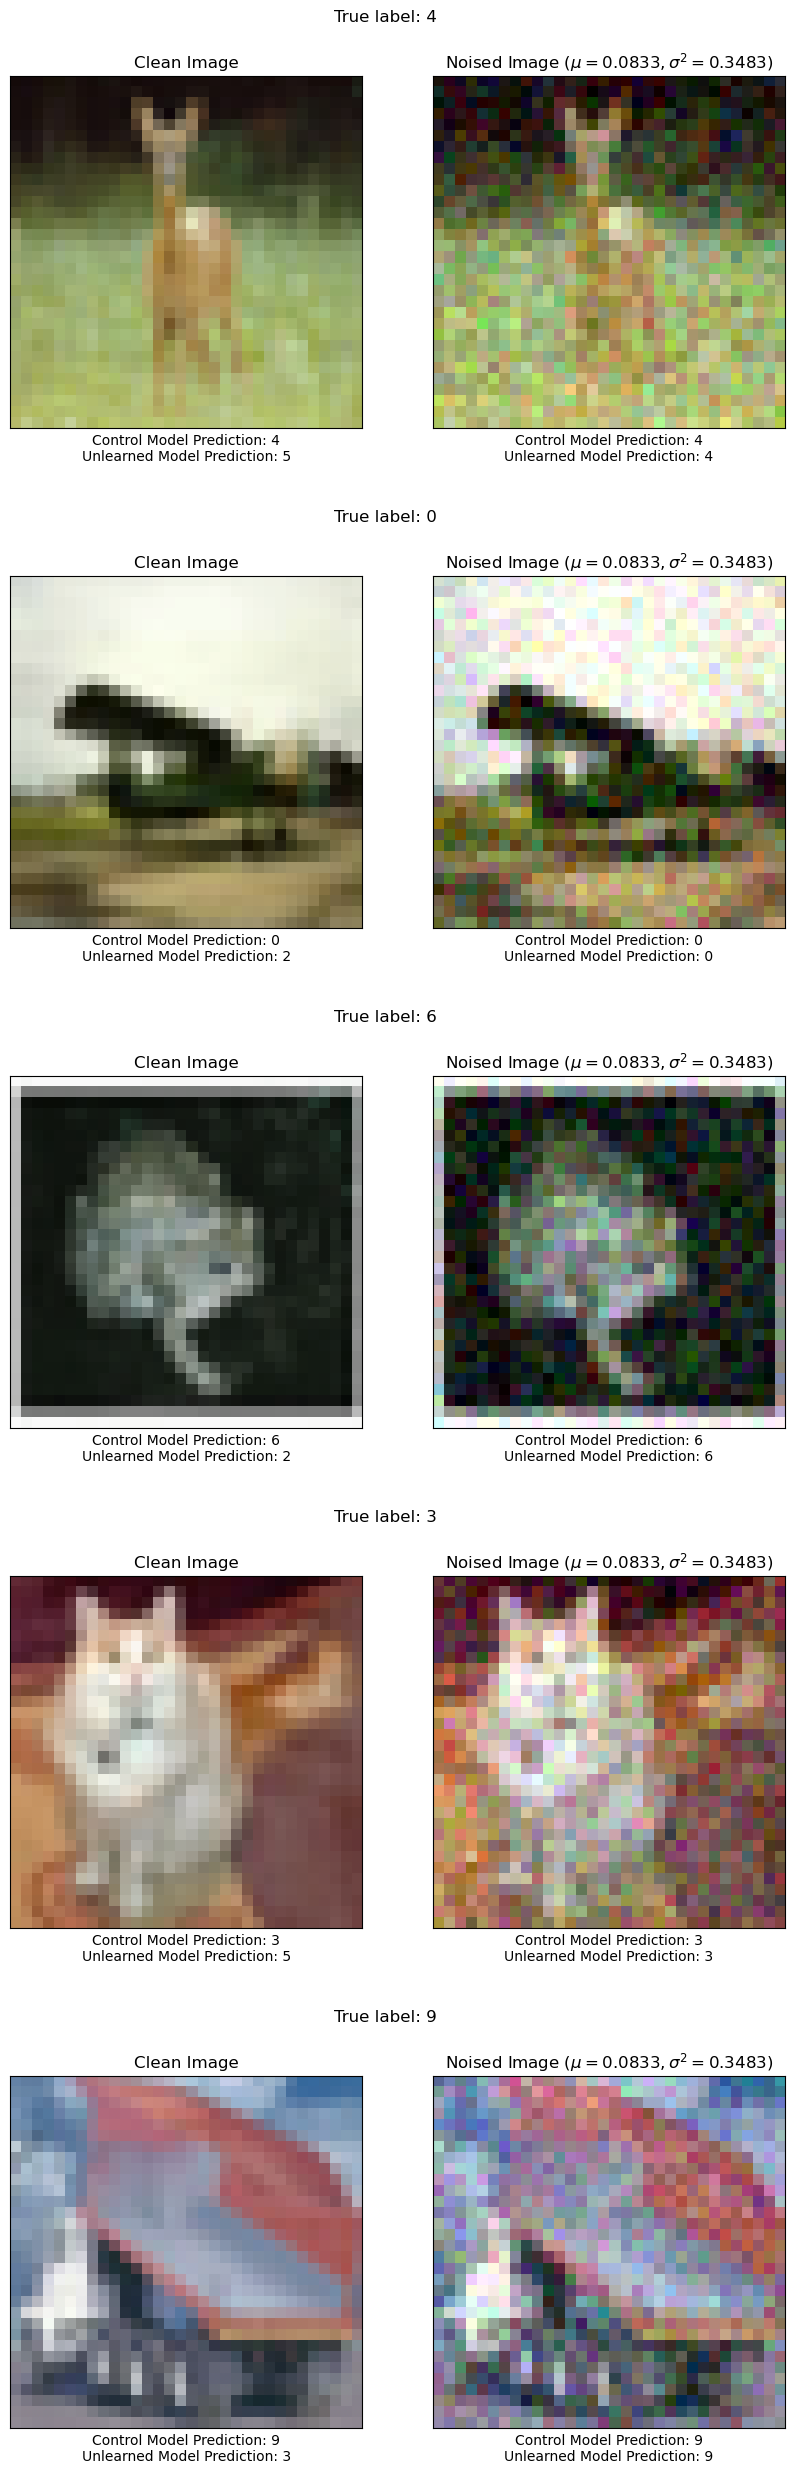

In [123]:
bad_indices = []
for i, (x, y) in enumerate(tqdm(clean_ds)):
    clean_pred = F.softmax(unlearned_model(x.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)
    noisy_pred = F.softmax(unlearned_model(adv_imgs[i].reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)
    if clean_pred != y and noisy_pred == y:
        bad_indices.append(i)
print(f'Found {len(bad_indices)} examples of recovered behavior')


num_examples = 5
fig = plt.figure(figsize=(10, 5 * min(num_examples, len(bad_indices))))
subfigs = fig.subfigures(min(num_examples, len(bad_indices)), 1)

for ind, subfig in zip(bad_indices[:num_examples], subfigs):
    img, label = clean_ds[ind]
    noisy_img = adv_imgs[ind]
    subfig.suptitle(f'True label: {label}')
    
    (ax1, ax2) = subfig.subplots(1, 2)
    
    plot_img(img, ax1)
    ax1.set(
        title='Clean Image',
        xlabel=f'Control Model Prediction: {F.softmax(control_model(img.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)}\nUnlearned Model Prediction: {F.softmax(unlearned_model(img.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)}',
        xticks=[], 
        yticks=[] 
    ) 
    
    plot_img(noisy_img, ax2)
    ax2.set(
        title=f'Noised Image ($\\mu = {mus[max_asr_inds[1]]:.4f}, \\sigma^2 = {sigmas[max_asr_inds[0]]:.4f}$)',
        xlabel=f'Control Model Prediction: {F.softmax(control_model(img.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)}\nUnlearned Model Prediction: {F.softmax(unlearned_model(noisy_img.reshape(1, 3, 32, 32).cuda()), dim=-1).view(-1).cpu().argmax(dim=-1)}',
        xticks=[],
        yticks=[]
    )
fig.show()